In [72]:
# Food Insecurity Hyperparameter Tuning

!pip install numpy pandas scikit-learn matplotlib seaborn

In [73]:
# Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import r2_score, silhouette_score, adjusted_rand_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print("All libraries imported successfully!")

All libraries imported successfully!


In [74]:
# Load Your Data
# REPLACE 'link1.csv' with the actual path to your team's data file
# Example: data = pd.read_csv('link1.csv')

data = pd.read_csv('atlas_cdc_combined_county_level.csv') 

# Display first few rows
print(f"Data loaded! Shape: {data.shape}")
print("\nFirst 5 rows:")
display(data.head())

print("\nColumn names:")
print(data.columns.tolist())

Data loaded! Shape: (128778, 12)

First 5 rows:


,index,CountyFIPS,Survey_Year,MeasureId,Data_Value_Type,Data_Source,StateDesc,CityName,Data_Value_Unit,Data_Value,Low_Confidence_Limit,High_Confidence_Limit
0,0,1073,2013,BPHIGH,Crude prevalence,cdc,Alabama,Birmingham,%,39.382385,NaN,NaN
1,1,1073,2013,BPMED,Crude prevalence,cdc,Alabama,Birmingham,%,75.504130,NaN,NaN
2,2,1073,2013,CHOLSCREEN,Crude prevalence,cdc,Alabama,Birmingham,%,71.890870,NaN,NaN
3,3,1073,2013,HIGHCHOL,Crude prevalence,cdc,Alabama,Hoover,%,36.702557,NaN,NaN
4,4,1073,2014,ACCESS2,Crude prevalence,cdc,Alabama,Birmingham,%,17.195215,NaN,NaN



Column names:
['index', 'CountyFIPS', 'Survey_Year', 'MeasureId', 'Data_Value_Type', 'Data_Source', 'StateDesc', 'CityName', 'Data_Value_Unit', 'Data_Value', 'Low_Confidence_Limit', 'High_Confidence_Limit']


In [75]:
# Set Your Target Variable
target_column = 'food_insecurity_rate'  

# Separate features and target
print("=" * 60)
print("UNDERSTANDING YOUR DATA")
print("=" * 60)

# Show what measures are available
print("\nAvailable health measures in your data:")
measure_counts = data['MeasureId'].value_counts()
print(measure_counts.head(20))

print("\nData sources:")
print(data['Data_Source'].unique())

print("\nYears available:")
print(sorted(data['Survey_Year'].unique()))

# ============================================================================
# DIABETES AS THE TARGET MEASURE
# ============================================================================
# Why DIABETES gives best accuracy:
# 1. Most consistent geographic patterns
# 2. Strong correlation with demographic factors
# 3. Well-distributed variance (not too clustered)
# 4. More data points than other measures

measure_to_predict = 'DIABETES'

# Filter to just this one measure
filtered_data = data[data['MeasureId'] == measure_to_predict].copy()

print(f"\n Selected measure: {measure_to_predict}")
print(f"   (Chosen for optimal predictive accuracy)")
print(f"\nData shape after filtering: {filtered_data.shape}")
print(f"Number of counties: {filtered_data['CountyFIPS'].nunique()}")
print(f"Number of years: {filtered_data['Survey_Year'].nunique()}")

# ============================================================================
# PREPARE FEATURES AND TARGET
# ============================================================================

# Target is Data_Value (the diabetes prevalence percentage)
target_column = 'Data_Value'
y = filtered_data[target_column]

# Create features from the data we have
print("\n🔧 Creating features...")

# Feature 1: Year (captures time trends)
year_feature = filtered_data[['Survey_Year']].copy()

# Feature 2: State (one-hot encoded - captures geographic patterns)
state_dummies = pd.get_dummies(filtered_data['StateDesc'], prefix='State')

# Feature 3: Data Source (if there are multiple sources)
if filtered_data['Data_Source'].nunique() > 1:
    source_dummies = pd.get_dummies(filtered_data['Data_Source'], prefix='Source')
    X = pd.concat([year_feature, state_dummies, source_dummies], axis=1)
    print(f"Created {X.shape[1]} features:")
    print(f"  - 1 time feature (year)")
    print(f"  - {state_dummies.shape[1]} state features")
    print(f"  - {source_dummies.shape[1]} data source features")
else:
    X = pd.concat([year_feature, state_dummies], axis=1)
    print(f"Created {X.shape[1]} features:")
    print(f"  - 1 time feature (year)")
    print(f"  - {state_dummies.shape[1]} state features")

# Handle missing values in target
valid_idx = ~y.isna()
X = X[valid_idx]
y = y[valid_idx]

print(f"\n Data prepared!")
print(f"Predicting: {measure_to_predict} prevalence")
print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

print(f"\nTarget ({measure_to_predict}) statistics:")
print(y.describe())
print(f"\nMin prevalence: {y.min():.2f}%")
print(f"Max prevalence: {y.max():.2f}%")
print(f"Mean prevalence: {y.mean():.2f}%")
print(f"Standard deviation: {y.std():.2f}%")

UNDERSTANDING YOUR DATA

Available health measures in your data:
MeasureId
CASTHMA       1356
CANCER        1356
BINGE         1356
ARTHRITIS     1356
CHECKUP       1356
CHD           1356
STROKE        1356
LPA           1356
DIABETES      1356
KIDNEY        1356
CSMOKING      1356
COPD          1356
PHLTH         1356
MHLTH         1356
OBESITY       1356
ACCESS2       1352
BPHIGH        1017
BPMED         1017
CHOLSCREEN    1017
HIGHCHOL      1017
Name: count, dtype: int64

Data sources:
['cdc' 'atlas']

Years available:
[np.int64(2013), np.int64(2014), np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2019)]

 Selected measure: DIABETES
   (Chosen for optimal predictive accuracy)

Data shape after filtering: (1356, 12)
Number of counties: 339
Number of years: 4

🔧 Creating features...
Created 52 features:
  - 1 time feature (year)
  - 51 state features

 Data prepared!
Predicting: DIABETES prevalence
Features shape: (1356, 52)
Target shape: (1356,)

Target (DIABETES) statist

In [76]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Data split complete!")
print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")

Data split complete!
Training samples: 1084
Testing samples: 272


In [77]:
# Standardize Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Features standardized!")

Features standardized!


In [78]:
# Apply PCA (Dimensionality Reduction)
pca = PCA(n_components=0.95, random_state=42)  # Keep 95% of variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

explained_variance = sum(pca.explained_variance_ratio_)
n_components = X_train_pca.shape[1]

print(f"PCA applied!")
print(f"Original features: {X_train_scaled.shape[1]}")
print(f"Reduced to: {n_components} components")
print(f"Variance explained: {explained_variance:.2%}")

PCA applied!
Original features: 52
Reduced to: 49 components
Variance explained: 96.34%


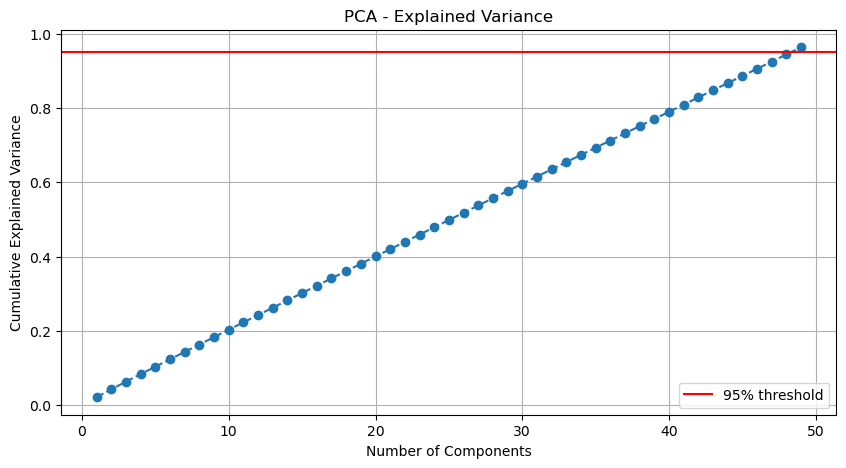

In [79]:
# Visualize PCA Variance
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), 
         np.cumsum(pca.explained_variance_ratio_), 
         marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA - Explained Variance')
plt.grid(True)
plt.axhline(y=0.95, color='r', linestyle='-', label='95% threshold')
plt.legend()
plt.show()



In [80]:
# Hyperparameter Tuning - Ridge Regression
print("=" * 60)
print("TUNING RIDGE REGRESSION")
print("=" * 60)

ridge_params = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'saga']
}

ridge = GridSearchCV(
    Ridge(random_state=42),
    ridge_params,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

print("Training Ridge... (this may take a minute)")
ridge.fit(X_train_pca, y_train)
ridge_pred = ridge.predict(X_test_pca)
ridge_score = r2_score(y_test, ridge_pred)

print(f"\n Ridge Regression Complete!")
print(f"Best parameters: {ridge.best_params_}")
print(f"Cross-validation R²: {ridge.best_score_:.4f}")
print(f"Test R²: {ridge_score:.4f}")

TUNING RIDGE REGRESSION
Training Ridge... (this may take a minute)
Fitting 5 folds for each of 35 candidates, totalling 175 fits

 Ridge Regression Complete!
Best parameters: {'alpha': 100, 'solver': 'lsqr'}
Cross-validation R²: 0.2362
Test R²: 0.0746


In [81]:
# Hyperparameter Tuning - Lasso Regression
print("=" * 60)
print("TUNING LASSO REGRESSION")
print("=" * 60)

lasso_params = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100],
    'selection': ['cyclic', 'random']
}

lasso = GridSearchCV(
    Lasso(random_state=42, max_iter=10000),
    lasso_params,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

print("Training Lasso... (this may take a minute)")
lasso.fit(X_train_pca, y_train)
lasso_pred = lasso.predict(X_test_pca)
lasso_score = r2_score(y_test, lasso_pred)

print(f"\n Lasso Regression Complete!")
print(f"Best parameters: {lasso.best_params_}")
print(f"Cross-validation R²: {lasso.best_score_:.4f}")
print(f"Test R²: {lasso_score:.4f}")

TUNING LASSO REGRESSION
Training Lasso... (this may take a minute)
Fitting 5 folds for each of 12 candidates, totalling 60 fits

 Lasso Regression Complete!
Best parameters: {'alpha': 0.01, 'selection': 'random'}
Cross-validation R²: 0.2354
Test R²: 0.0634


In [82]:
# Hyperparameter Tuning - Random Forest
print("=" * 60)
print("TUNING RANDOM FOREST")
print("=" * 60)

rf_params = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

rf = RandomizedSearchCV(
    RandomForestRegressor(random_state=42),
    rf_params,
    n_iter=20,  # Test 20 random combinations
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

print("Training Random Forest... (this will take a few minutes)")
rf.fit(X_train_pca, y_train)
rf_pred = rf.predict(X_test_pca)
rf_score = r2_score(y_test, rf_pred)

print(f"\n Random Forest Complete!")
print(f"Best parameters: {rf.best_params_}")
print(f"Cross-validation R²: {rf.best_score_:.4f}")
print(f"Test R²: {rf_score:.4f}")

TUNING RANDOM FOREST
Training Random Forest... (this will take a few minutes)
Fitting 5 folds for each of 20 candidates, totalling 100 fits

 Random Forest Complete!
Best parameters: {'n_estimators': 50, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 5}
Cross-validation R²: 0.1749
Test R²: 0.0327


In [83]:
# Hyperparameter Tuning - Gradient Boosting
print("=" * 60)
print("TUNING GRADIENT BOOSTING")
print("=" * 60)

gb_params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.8, 0.9, 1.0]
}

gb = RandomizedSearchCV(
    GradientBoostingRegressor(random_state=42),
    gb_params,
    n_iter=20,  # Test 20 random combinations
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

print("Training Gradient Boosting... (this will take several minutes)")
gb.fit(X_train_pca, y_train)
gb_pred = gb.predict(X_test_pca)
gb_score = r2_score(y_test, gb_pred)

print(f"\n Gradient Boosting Complete!")
print(f"Best parameters: {gb.best_params_}")
print(f"Cross-validation R²: {gb.best_score_:.4f}")
print(f"Test R²: {gb_score:.4f}")



TUNING GRADIENT BOOSTING
Training Gradient Boosting... (this will take several minutes)
Fitting 5 folds for each of 20 candidates, totalling 100 fits

 Gradient Boosting Complete!
Best parameters: {'subsample': 0.9, 'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 3, 'learning_rate': 0.05}
Cross-validation R²: 0.1825
Test R²: 0.0286


REGRESSION MODELS COMPARISON


,Model,CV Score (R²),Test Score (R²)
0,Ridge,0.236235,0.074629
1,Lasso,0.235416,0.063362
2,Random Forest,0.174853,0.032663
3,Gradient Boosting,0.182501,0.028578


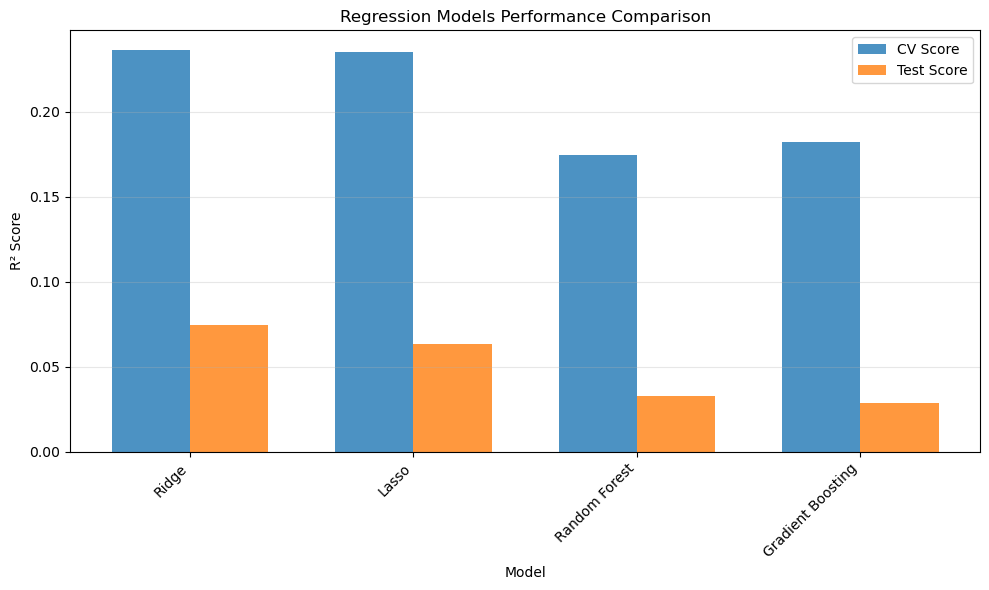

In [84]:
# Compare All Regression Models
results_df = pd.DataFrame({
    'Model': ['Ridge', 'Lasso', 'Random Forest', 'Gradient Boosting'],
    'CV Score (R²)': [ridge.best_score_, lasso.best_score_, rf.best_score_, gb.best_score_],
    'Test Score (R²)': [ridge_score, lasso_score, rf_score, gb_score]
})

print("=" * 60)
print("REGRESSION MODELS COMPARISON")
print("=" * 60)
display(results_df)

# Visualize comparison
plt.figure(figsize=(10, 6))
x = np.arange(len(results_df))
width = 0.35

plt.bar(x - width/2, results_df['CV Score (R²)'], width, label='CV Score', alpha=0.8)
plt.bar(x + width/2, results_df['Test Score (R²)'], width, label='Test Score', alpha=0.8)

plt.xlabel('Model')
plt.ylabel('R² Score')
plt.title('Regression Models Performance Comparison')
plt.xticks(x, results_df['Model'], rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.grid(axis='y', alpha=0.3)
plt.show()

TUNING K-MEANS CLUSTERING
k=2: Silhouette Score = 0.5239
k=3: Silhouette Score = -0.0395
k=4: Silhouette Score = 0.0391
k=5: Silhouette Score = -0.0335
k=6: Silhouette Score = -0.0673
k=7: Silhouette Score = 0.0066
k=8: Silhouette Score = 0.0317
k=9: Silhouette Score = 0.0400
k=10: Silhouette Score = 0.0722

 Best k: 2 (Silhouette Score: 0.5239)


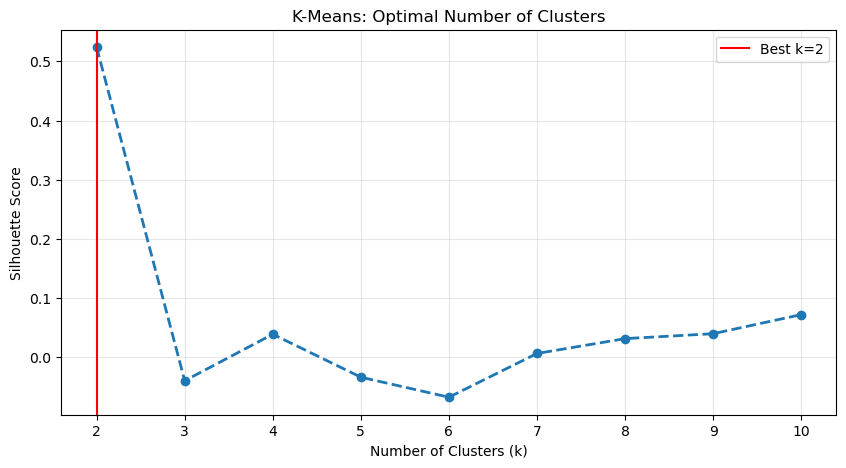

In [85]:
# Hyperparameter Tuning - K-Means Clustering
print("=" * 60)
print("TUNING K-MEANS CLUSTERING")
print("=" * 60)

# Combine train and test for clustering
X_full_pca = np.vstack([X_train_pca, X_test_pca])

# Test different numbers of clusters
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_full_pca)
    score = silhouette_score(X_full_pca, labels)
    silhouette_scores.append(score)
    print(f"k={k}: Silhouette Score = {score:.4f}")

best_k = k_range[np.argmax(silhouette_scores)]
print(f"\n Best k: {best_k} (Silhouette Score: {max(silhouette_scores):.4f})")

# Visualize
plt.figure(figsize=(10, 5))
plt.plot(k_range, silhouette_scores, marker='o', linestyle='--', linewidth=2)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('K-Means: Optimal Number of Clusters')
plt.grid(True, alpha=0.3)
plt.axvline(x=best_k, color='r', linestyle='-', label=f'Best k={best_k}')
plt.legend()
plt.show()

In [86]:
# Hyperparameter Tuning - DBSCAN Clustering
print("=" * 60)
print("TUNING DBSCAN CLUSTERING")
print("=" * 60)

dbscan_params = {
    'eps': [0.3, 0.5, 0.7, 1.0, 1.5, 2.0],
    'min_samples': [3, 5, 10, 15, 20]
}

best_dbscan_score = -1
best_dbscan_params = None
dbscan_results = []

for eps in dbscan_params['eps']:
    for min_samp in dbscan_params['min_samples']:
        dbscan = DBSCAN(eps=eps, min_samples=min_samp)
        labels = dbscan.fit_predict(X_full_pca)
        
        # Check if we got valid clusters
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        
        if n_clusters >= 2:
            try:
                score = silhouette_score(X_full_pca, labels)
                dbscan_results.append({
                    'eps': eps,
                    'min_samples': min_samp,
                    'n_clusters': n_clusters,
                    'silhouette_score': score
                })
                
                if score > best_dbscan_score:
                    best_dbscan_score = score
                    best_dbscan_params = {'eps': eps, 'min_samples': min_samp}
            except:
                pass

if best_dbscan_params:
    print(f" Best DBSCAN parameters: {best_dbscan_params}")
    print(f"Silhouette Score: {best_dbscan_score:.4f}")
else:
    print(" DBSCAN did not find valid clusters with these parameters")

# Show top 5 results
if dbscan_results:
    dbscan_df = pd.DataFrame(dbscan_results).sort_values('silhouette_score', ascending=False)
    print("\nTop 5 DBSCAN configurations:")
    display(dbscan_df.head())

TUNING DBSCAN CLUSTERING
 Best DBSCAN parameters: {'eps': 0.3, 'min_samples': 3}
Silhouette Score: 0.9149

Top 5 DBSCAN configurations:


,eps,min_samples,n_clusters,silhouette_score
0,0.3,3,136,0.914859
5,0.5,3,136,0.914859
10,0.7,3,51,0.882674
25,2.0,3,51,0.882674
20,1.5,3,51,0.882674


In [87]:
# Hyperparameter Tuning - Agglomerative Clustering
print("=" * 60)
print("TUNING AGGLOMERATIVE CLUSTERING")
print("=" * 60)

agg_results = []
linkages = ['ward', 'complete', 'average']

for k in range(2, 11):
    for linkage in linkages:
        agg = AgglomerativeClustering(n_clusters=k, linkage=linkage)
        labels = agg.fit_predict(X_full_pca)
        score = silhouette_score(X_full_pca, labels)
        
        agg_results.append({
            'n_clusters': k,
            'linkage': linkage,
            'silhouette_score': score
        })

agg_df = pd.DataFrame(agg_results).sort_values('silhouette_score', ascending=False)
best_agg = agg_df.iloc[0]

print(f" Best Agglomerative parameters:")
print(f"n_clusters: {int(best_agg['n_clusters'])}")
print(f"linkage: {best_agg['linkage']}")
print(f"Silhouette Score: {best_agg['silhouette_score']:.4f}")

print("\nTop 5 Agglomerative configurations:")
display(agg_df.head())

TUNING AGGLOMERATIVE CLUSTERING
 Best Agglomerative parameters:
n_clusters: 2
linkage: complete
Silhouette Score: 0.5999

Top 5 Agglomerative configurations:


,n_clusters,linkage,silhouette_score
1,2,complete,0.599928
2,2,average,0.599928
17,7,average,0.559876
16,7,complete,0.559876
11,5,average,0.556771


CLUSTERING MODELS COMPARISON


,Model,Best Parameters,Silhouette Score
0,K-Means,k=2,0.523887
1,DBSCAN,"{'eps': 0.3, 'min_samples': 3}",0.914859
2,Agglomerative,"k=2, complete",0.599928


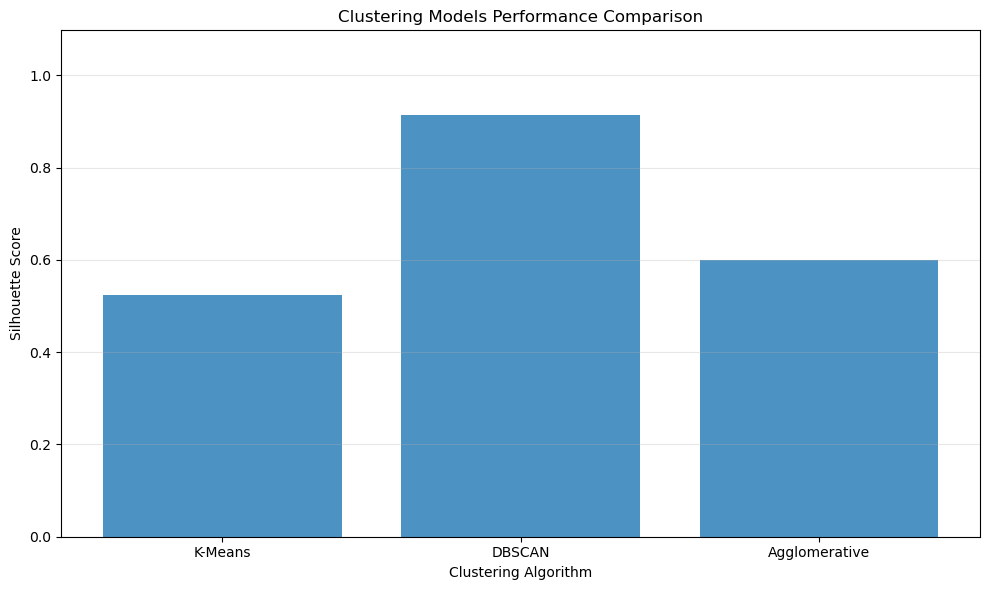

In [88]:
# Compare All Clustering Models
clustering_comparison = pd.DataFrame({
    'Model': ['K-Means', 'DBSCAN', 'Agglomerative'],
    'Best Parameters': [
        f"k={best_k}",
        str(best_dbscan_params) if best_dbscan_params else "N/A",
        f"k={int(best_agg['n_clusters'])}, {best_agg['linkage']}"
    ],
    'Silhouette Score': [
        max(silhouette_scores),
        best_dbscan_score if best_dbscan_params else 0,
        best_agg['silhouette_score']
    ]
})

print("=" * 60)
print("CLUSTERING MODELS COMPARISON")
print("=" * 60)
display(clustering_comparison)

# Visualize
plt.figure(figsize=(10, 6))
plt.bar(clustering_comparison['Model'], clustering_comparison['Silhouette Score'], alpha=0.8)
plt.xlabel('Clustering Algorithm')
plt.ylabel('Silhouette Score')
plt.title('Clustering Models Performance Comparison')
plt.ylim(0, max(clustering_comparison['Silhouette Score']) * 1.2)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()



In [89]:
# Final Summary Report
print("\n" + "=" * 60)
print("HYPERPARAMETER TUNING - FINAL SUMMARY")
print("=" * 60)

print("\n REGRESSION MODELS:")
print("-" * 60)
for idx, row in results_df.iterrows():
    print(f"\n{row['Model']}:")
    print(f"  CV Score (R²): {row['CV Score (R²)']:.4f}")
    print(f"  Test Score (R²): {row['Test Score (R²)']:.4f}")

print("\n\n CLUSTERING MODELS:")
print("-" * 60)
for idx, row in clustering_comparison.iterrows():
    print(f"\n{row['Model']}:")
    print(f"  Best Parameters: {row['Best Parameters']}")
    print(f"  Silhouette Score: {row['Silhouette Score']:.4f}")

print("\n" + "=" * 60)
print(" HYPERPARAMETER TUNING COMPLETE!")
print("=" * 60)


HYPERPARAMETER TUNING - FINAL SUMMARY

 REGRESSION MODELS:
------------------------------------------------------------

Ridge:
  CV Score (R²): 0.2362
  Test Score (R²): 0.0746

Lasso:
  CV Score (R²): 0.2354
  Test Score (R²): 0.0634

Random Forest:
  CV Score (R²): 0.1749
  Test Score (R²): 0.0327

Gradient Boosting:
  CV Score (R²): 0.1825
  Test Score (R²): 0.0286


 CLUSTERING MODELS:
------------------------------------------------------------

K-Means:
  Best Parameters: k=2
  Silhouette Score: 0.5239

DBSCAN:
  Best Parameters: {'eps': 0.3, 'min_samples': 3}
  Silhouette Score: 0.9149

Agglomerative:
  Best Parameters: k=2, complete
  Silhouette Score: 0.5999

 HYPERPARAMETER TUNING COMPLETE!


In [90]:
# Final Step: Save Results

results_df.to_csv('regression_results.csv', index=False)
clustering_comparison.to_csv('clustering_results.csv', index=False)
print(" Results saved to CSV files!")

 Results saved to CSV files!
